In [1]:
import pandas as pd
import numpy as np
import collections
import os, json, pickle
from tqdm import tqdm
from scipy import stats
from glob import glob
from itertools import combinations
#from venn import venn
from matplotlib import pyplot 
from utils import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr
import plotly.express as px
import os
from tqdm import tqdm


In [6]:
df1 = pd.read_csv('../data/synergy_responses_with_monotherapy.tsv', sep='\t')
df1['dataset'] = 'train'
df2 = pd.read_csv('../data/hold_out/ho1/synergy_responses_with_monotherapy.tsv', sep='\t')
df2['dataset'] = 'ho1'
df3 = pd.read_csv('../data/hold_out/ho2/synergy_responses_with_monotherapy.tsv', sep='\t')
df3['dataset'] = 'ho2'
df = pd.concat([df1, df2, df3], ignore_index=True)

# TODO: monotherapy
df1_mono = pd.read_csv('../data/monotherapy_responses.tsv', sep='\t')
df1_mono['dataset'] = 'train'
df2_mono = pd.read_csv('../data/hold_out/ho1/monotherapy_responses.tsv', sep='\t')
df2_mono['dataset'] = 'ho1'
df3_mono = pd.read_csv('../data/hold_out/ho2/monotherapy_responses.tsv', sep='\t')
df3_mono['dataset'] = 'ho2'
df_mono = pd.concat([df1_mono, df2_mono, df3_mono], ignore_index=True)
#df[['.identifier_sample_name', '.metadata_cancer_type', 'dataset']].drop_duplicates().to_csv('./tmp/cell_line_info.tsv', sep='\t', index=False)

In [3]:
# 1. how many dataset in training/hold-out 1 and 2
print(df1.shape, df2.shape, df3.shape) # (17912, 11) (4247, 11) (668, 11)

# 2. how many cell line/tissue in training/hold-out 1 and 2
print(len(df1['.identifier_sample_name'].unique()), len(df2['.identifier_sample_name'].unique()), len(df3['.identifier_sample_name'].unique())) # 62 16 8
print(len(df1['.metadata_cancer_type'].unique()), len(df2['.metadata_cancer_type'].unique()), len(df3['.metadata_cancer_type'].unique())) # 12 12 2
print(len(df1['.metadata_cancer_subtype'].unique()), len(df2['.metadata_cancer_subtype'].unique()), len(df3['.metadata_cancer_subtype'].unique())) # 24 15 2

# 3. how many drugs/combination in each of them
print(len(set(df1['.metadata_treatment_1'].to_list()+df1['.metadata_treatment_2'].to_list()))) # 87
print(len(set(df2['.metadata_treatment_1'].to_list()+df2['.metadata_treatment_2'].to_list()))) # 87
print(len(set(df3['.metadata_treatment_1'].to_list()+df3['.metadata_treatment_2'].to_list()))) # 16

# 4. how many mode of actions
print(len(set(df1['.metadata_moa_1'].to_list()+df1['.metadata_moa_2'].to_list()))) # 61


# different combinations
df['combination']=['+'.join(sorted([r['.metadata_treatment_1'],r['.metadata_treatment_2']])) for _, r in df.iterrows()]
df.groupby('dataset').nunique()['combination']
"""
dataset unique combinations
ho1      478
ho2       25
train    478
"""
# replicability of each dataset
# train
"""
Total treatment in monotherapy: 90
Total treatment in combination therapy: 87
Total cell lines in monotherapy: 62
Total cell lines in combination therapy: 62
Total cell lines in monotherapy: 12
Total cell lines in combination therapy: 12
Averge # cellines tested for drug pairs: 27.947698744769873
Overall reproducibility (AOC) Pearson: 0.7003465141381711	0.0; Spearman: 0.7231740698842666	0.0
Overall reproducibility (Bliss) Pearson: 0.7576155372135673	1.746406496786e-312; Spearman: 0.7448910446349724	1.6113512902816565e-296
Monotherapy reproducibility (AOC) Pearson: 0.8350392272792175	0.0; Spearman: 0.805590466351589	0.0
Synergy reproducibility (AOC) Pearson: -0.022562203238515287	0.39061011175384497; Spearman: 0.036081105118420304	0.1696933573800796
Synergy reproducibility (Bliss) Pearson: 0.7611272797055482	3.74540113612947e-306; Spearman: 0.7553674938799363	6.139356145228265e-299
"""
# ho1
"""
Total treatment in monotherapy: 90
Total treatment in combination therapy: 87
Total cell lines in monotherapy: 16
Total cell lines in combination therapy: 16
Total cell lines in monotherapy: 12
Total cell lines in combination therapy: 12
Averge # cellines tested for drug pairs: 6.5
Overall reproducibility (AOC) Pearson: 0.6410553580264177	4.6039651226920623e-302; Spearman: 0.6882184052153105	0.0
Overall reproducibility (Bliss) Pearson: 0.7419220117681018	2.631869646053991e-68; Spearman: 0.7052944592572497	4.874900046468296e-59
Monotherapy reproducibility (AOC) Pearson: 0.845033948670617	0.0; Spearman: 0.8207326570199635	0.0
Synergy reproducibility (AOC) Pearson: -0.21319939124050324	8.601345293855101e-05; Spearman: -0.12268976370140947	0.024941416491662052
Synergy reproducibility (Bliss) Pearson: 0.7438836383128478	9.699434844065291e-67; Spearman: 0.7170720835500471	5.711992504129799e-60
"""
# ho2
"""
Total treatment in monotherapy: 23
Total treatment in combination therapy: 16
Total cell lines in monotherapy: 8
Total cell lines in combination therapy: 8
Total cell lines in monotherapy: 2
Total cell lines in combination therapy: 2
Averge # cellines tested for drug pairs: 7.88
Overall reproducibility (AOC) Pearson: 0.8143786933844415	6.261433785321603e-81; Spearman: 0.7477610929751504	2.3019059689477995e-61
Overall reproducibility (Bliss) Pearson: nan	nan; Spearman: nan	nan
Monotherapy reproducibility (AOC) Pearson: 0.8143786933844415	6.261433785321603e-81; Spearman: 0.7477610929751504	2.3019059689477995e-61
Synergy reproducibility (AOC) Pearson: nan	nan; Spearman: nan	nan
Synergy reproducibility (Bliss) Pearson: nan	nan; Spearman: nan	nan
"""
# TODO: combine ho1 and ho2 and compute reproducibility

response_h1 = pd.read_csv('../data/hold_out/ho1/processedmerck_confidential_responses_ho1_20200221.tsv', sep = '\t')
response_h2 = pd.read_csv('../data/hold_out/ho2/processedmerck_confidential_responses_ho2_20200221.tsv', sep = '\t')
responses = pd.concat([response_h1, response_h2], ignore_index=True)

responses, monotherapy, synergy = split_monotherapy_synergy(responses)
freq_sum, r1,p1,r2, p2 = check_reproducibility(responses, 'synergy', 'aoc')
print("Overall reproducibility (AOC) Pearson: "+str(r1)+'\t'+str(p1)+ "; Spearman: "+str(r2)+'\t'+str(p2)+'\n')
freq_sum, r1,p1,r2, p2 = check_reproducibility(responses, 'synergy', 'bliss')
print("Overall reproducibility (Bliss) Pearson: "+str(r1)+'\t'+str(p1)+ "; Spearman: "+str(r2)+'\t'+str(p2)+'\n')
# Overall reproducibility (Bliss) Pearson: 0.7419220117681018	2.631869646053991e-68; Spearman: 0.7052944592572497	4.874900046468296e-59

# check monotherapy reprodicibility
freq_sum, r1,p1,r2, p2 = check_reproducibility(monotherapy, 'monotherapy', 'aoc')
print("Monotherapy reproducibility (AOC) Pearson: "+str(r1)+'\t'+str(p1)+ "; Spearman: "+str(r2)+'\t'+str(p2)+'\n')
# Monotherapy reproducibility (AOC) Pearson: 0.8428501279869431	0.0; Spearman: 0.8146133519197033	0.0

# replicability between dataset: no overlap between datasets
# PCA/tsne of each dataset

(17912, 12) (4247, 12) (668, 12)
62 16 8
12 12 2
24 15 2
87
87
16
61


/local/encrypted1/rayezh/Merck_publication_3/feature/QC/utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['.metadata_treatment_comb'] = ['_'.join(sorted(list(x))) for _,x in data[['.metadata_treatment_1','.metadata_treatment_2']].iterrows()]
/local/encrypted1/rayezh/Merck_publication_3/feature/QC/utils.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['.metadata_treatment_remarks'] = data['.metadata_treatment_remarks'].fillna('')
/local/encrypted1/rayezh/Merck_publication_3/feature/QC/

number of replicates: 692
Reproducibility (Pearson's cor) of aoc across replicated experiments on synergy dataset is 0.6532299577933877 , p = 0.0
Reproducibility (Spearman's cor) of aoc across replicated experiments on synergy dataset is 0.6960173738598178 , p = 0.0
Overall reproducibility (AOC) Pearson: 0.6532299577933877	0.0; Spearman: 0.6960173738598178	0.0



/local/encrypted1/rayezh/Merck_publication_3/feature/QC/utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['.metadata_treatment_comb'] = ['_'.join(sorted(list(x))) for _,x in data[['.metadata_treatment_1','.metadata_treatment_2']].iterrows()]
/local/encrypted1/rayezh/Merck_publication_3/feature/QC/utils.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['.metadata_treatment_remarks'] = data['.metadata_treatment_remarks'].fillna('')
/local/encrypted1/rayezh/Merck_publication_3/feature/QC/

number of replicates: 132
Reproducibility (Pearson's cor) of bliss across replicated experiments on synergy dataset is 0.7419220117681018 , p = 2.631869646053991e-68
Reproducibility (Spearman's cor) of bliss across replicated experiments on synergy dataset is 0.7052944592572497 , p = 4.874900046468296e-59
Overall reproducibility (Bliss) Pearson: 0.7419220117681018	2.631869646053991e-68; Spearman: 0.7052944592572497	4.874900046468296e-59

number of replicates: 579
Reproducibility (Pearson's cor) of aoc across replicated experiments on monotherapy dataset is 0.8428501279869431 , p = 0.0
Reproducibility (Spearman's cor) of aoc across replicated experiments on monotherapy dataset is 0.8146133519197033 , p = 0.0
Monotherapy reproducibility (AOC) Pearson: 0.8428501279869431	0.0; Spearman: 0.8146133519197033	0.0



In [4]:
# compute reproduciility of each combinations
df_tmp =df.copy()
# exclude gamma from treatment
df_tmp = df_tmp[~df_tmp['.metadata_treatment_1'].str.contains('gamma')]
df_tmp = df_tmp[~df_tmp['.metadata_treatment_2'].str.contains('gamma')]
df_tmp['.metadata_treatment_remarks'] = df_tmp['.metadata_treatment_remarks'].fillna('')
df_tmp['comb_cell']= ['+'.join(sorted([r['.metadata_treatment_1'],r['.metadata_treatment_2']]))+'_'+r['.identifier_sample_name'] for _, r in df_tmp.iterrows()]
df_tmp['comb']= ['+'.join(sorted([r['.metadata_treatment_1'],r['.metadata_treatment_2']])) for _, r in df_tmp.iterrows()]

from scipy import stats

# tissue specificity compared to reproducibiltiy
all_score_aoc = []
all_score_bliss = []
for comb in tqdm(df_tmp['comb'].unique()):
    df_sub = df_tmp[df_tmp['comb']==comb]
    score = df_sub['.response_aoc'].dropna().to_list()
    score_pair = [[x,y] for x, y in permutations(score,2)]
    all_score_aoc.extend(score_pair)
    score = df_sub['.response_bliss'].dropna().to_list()
    score_pair = [[x,y] for x, y in permutations(score,2)]
    all_score_bliss.extend(score_pair)

all_score_aoc = np.array(all_score_aoc)
all_score_bliss = np.array(all_score_bliss)
r1,p1 = stats.pearsonr(all_score_aoc[:,0], all_score_aoc[:,1])
r2,p2 = stats.pearsonr(all_score_bliss[:,0], all_score_bliss[:,1])
print(all_score_aoc.shape, all_score_bliss.shape)
print('reprodicibility between combinations:')
print('aoc:', r1,p1)
print('bliss:', r2,p2) #0.3754221066721539 0.0 0.5724943145793199 0.0

# tissue specificity compared to reproducibiltiy
all_score_aoc = []
all_score_bliss = []
for comb in tqdm(df_tmp['comb_cell'].unique()):
    df_sub = df_tmp[df_tmp['comb_cell']==comb]
    score = df_sub['.response_aoc'].dropna().to_list()
    score_pair = [[x,y] for x, y in permutations(score,2)]
    all_score_aoc.extend(score_pair)
    score = df_sub['.response_bliss'].dropna().to_list()
    score_pair = [[x,y] for x, y in permutations(score,2)]
    all_score_bliss.extend(score_pair)

all_score_aoc = np.array(all_score_aoc)
all_score_bliss = np.array(all_score_bliss)
r1,p1 = stats.pearsonr(all_score_aoc[:,0], all_score_aoc[:,1])
r2,p2 = stats.pearsonr(all_score_bliss[:,0], all_score_bliss[:,1])
print(all_score_aoc.shape, all_score_bliss.shape)
print('reprodicibility between combinations-cell lines:')
print('aoc:', r1,p1)
print('bliss:', r2,p2) #0.12484584698108782 3.887718757477593e-80 0.6213268579328607 2e-323



# for the same drug comb: 0.27684458216473085 0.0 0.5672550807329749 0.0
# for the same drug-cellline pair: 0.22264220220637077 0.0 0.6229910849589071 0.0

#for each combination, check the 

# TODO: in utils.py, for each combination, check the the prediction performances across different cell lines

"""
results = {'combination':[], 'reproducibility_aoc':[], 'reproducibility_bliss':[], 'baseline_aoc':[], 'baseline_bliss':[], 'reproducibility_aoc_cell':[], 'reproducibility_bliss_cell':[]}
for comb in tqdm(df_tmp['comb'].unique()):
    print(comb)
    df_sub = df_tmp[df_tmp['comb']==comb]
    score = df_sub['.response_aoc'].dropna().to_list()
    if len(score)>=2:
        score_pair = np.array([[x,y] for x, y in permutations(score,2)])
        cor, p = stats.pearsonr(score_pair[:,0], score_pair[:,1])
    else:
        cor = np.nan
    results['combination'].append(comb)
    results['reproducibility_aoc'].append(cor)
    results['baseline_aoc'].append(0.8350)

    score = df_sub['.response_bliss'].dropna().to_list()
    if len(score)>=2:
        score_pair = np.array([[x,y] for x, y in permutations(score,2)])
        cor, p = stats.pearsonr(score_pair[:,0], score_pair[:,1])
    else:
        cor = np.nan
    results['reproducibility_bliss'].append(cor)
    results['baseline_bliss'].append(0.7611)

    # for this combination, check the prediction performances across different cell lines
    score_pair_aoc = []
    score_pair_bliss = []
    for j in df_sub['comb_cell'].unique():
        df_sub_sub = df_sub[df_sub['comb_cell']==j]
        score = df_sub_sub['.response_aoc'].dropna().to_list()
        if len(score)>=2:
            score_pair = np.array([[x,y] for x, y in permutations(score,2)])
            score_pair_aoc.extend(score_pair)
        score = df_sub_sub['.response_bliss'].dropna().to_list()
        if len(score)>=2:
            score_pair = np.array([[x,y] for x, y in permutations(score,2)])
            score_pair_bliss.extend(score_pair)
    score_pair_aoc = np.array(score_pair_aoc)
    score_pair_bliss = np.array(score_pair_bliss)
    #print(score_pair_aoc.shape, score_pair_bliss.shape)
    if score_pair_aoc.shape[0]==0:
        cor = np.nan
    else:
        cor, p = stats.pearsonr(score_pair_aoc[:,0], score_pair_aoc[:,1])
        print(cor, p, score_pair_aoc.shape)
    results['reproducibility_aoc_cell'].append(cor) 
    if score_pair_bliss.shape[0]==0:
        cor = np.nan
    else:
        cor, p = stats.pearsonr(score_pair_bliss[:,0], score_pair_bliss[:,1])
        print(cor, p, score_pair_bliss.shape)
    results['reproducibility_bliss_cell'].append(cor)
    

results = pd.DataFrame(results)

"""


  1%|          | 101/16491 [00:00<00:16, 1002.03it/s]

(2680136, 2) (835048, 2)
reprodicibility between combinations:
aoc: 0.3754221066721539 0.0
bliss: 0.5724943145793199 0.0


100%|██████████| 16491/16491 [00:15<00:00, 1039.50it/s]

(22878, 2) (3034, 2)
reprodicibility between combinations-cell lines:
aoc: 0.12484584698108782 3.887718757477593e-80
bliss: 0.6213268579328607 2e-323


"\nresults = {'combination':[], 'reproducibility_aoc':[], 'reproducibility_bliss':[], 'baseline_aoc':[], 'baseline_bliss':[], 'reproducibility_aoc_cell':[], 'reproducibility_bliss_cell':[]}\nfor comb in tqdm(df_tmp['comb'].unique()):\n    print(comb)\n    df_sub = df_tmp[df_tmp['comb']==comb]\n    score = df_sub['.response_aoc'].dropna().to_list()\n    if len(score)>=2:\n        score_pair = np.array([[x,y] for x, y in permutations(score,2)])\n        cor, p = stats.pearsonr(score_pair[:,0], score_pair[:,1])\n    else:\n        cor = np.nan\n    results['combination'].append(comb)\n    results['reproducibility_aoc'].append(cor)\n    results['baseline_aoc'].append(0.8350)\n\n    score = df_sub['.response_bliss'].dropna().to_list()\n    if len(score)>=2:\n        score_pair = np.array([[x,y] for x, y in permutations(score,2)])\n        cor, p = stats.pearsonr(score_pair[:,0], score_pair[:,1])\n    else:\n        cor = np.nan\n    results['reproducibility_bliss'].append(cor)\n    results[

In [10]:
df_tmp_new = df_tmp.rename(columns={'.identifier_sample_name':'cell_line', '.response_aoc':'aoc', '.response_bliss':'bliss'})
df_aoc = df_tmp_new[['cell_line', 'comb', 'aoc']].dropna().reset_index(drop=True)
df_bliss = df_tmp_new[['cell_line', 'comb', 'bliss']].dropna().reset_index(drop=True)
df_aoc.to_csv('./tmp/aoc_anova.csv', index=False)
df_bliss.to_csv('./tmp/bliss_anova.csv', index=False)


In [ ]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols 

model = ols('aoc ~ C(comb) + C(cell_line) + C(comb):C(cell_line)', 
            data=df_aoc.sample(2000)).fit() 
result = sm.stats.anova_lm(model, type=2, robust='hc3') 
  
# Print the result 
print(result) 


In [ ]:
model = ols('bliss ~ C(comb) + C(cell_line) + C(comb):C(cell_line)', 
            data=df_bliss.sample(2000)).fit() 
result = sm.stats.anova_lm(model, type=2, robust='hc3') 
  
# Print the result 
print(result) 

<Axes: ylabel='Frequency'>

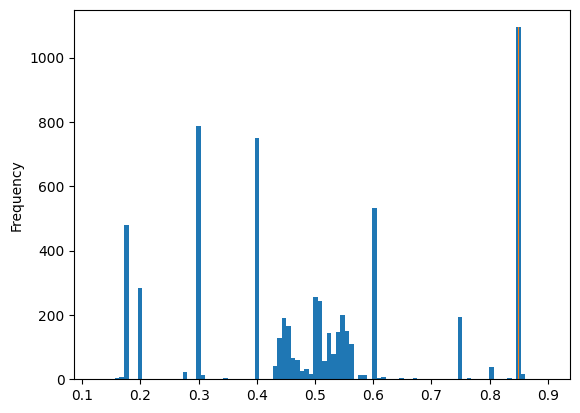

In [25]:
# synthetic lethality only take certain pairs:
df = pd.read_csv('../synthetic_lethality_features/Human_SL.csv')
# read ddr genes
with open('./ddr_gene.txt') as f:
    ddr_genes = f.read().splitlines()
# take lines in df that both n1.name and n2.name are in ddr_genes
df = df[df.apply(lambda x: x['n1.name'] in ddr_genes and x['n2.name'] in ddr_genes, axis=1)]
# plot distribution of synthetic lethality score
df['r.statistic_score'].plot.hist(bins=100)

# take pairs with score cutoff of 0.8
df_new = df[(df['r.statistic_score']>=0.8)]
df_new.to_csv('../synthetic_lethality_features/Human_SL_0.8.csv', index=False) 
# plot distribution of synthetic lethality score
df_new['r.statistic_score'].plot.hist(bins=100)

In [69]:
# tsne of the molecular sigatures
def tsne(df, f = None, n = 2, r = 0):
    """
    tsne of cell line features

    params:
        df: molecular marker profiles of all cell lines tested
        f: feature type, "_exp", "_lof", "_cnv", "snv", "_ddr", "__coh_pat", "__lof_pat" ; if None, using all features
        n: number of principle components
    """
    from sklearn.manifold import TSNE 
    from sklearn.preprocessing import StandardScaler
    cell_line = df['.identifier_sample_name']
    cancer_type = df['.metadata_cancer_type']
    cancer_subtype = df['.metadata_cancer_subtype']
    dataset = df['dataset']
    if f:
        new_cols = [i for i in df.columns if i.endswith(f)]
    else:
        new_cols = df.columns[1:-3]
    df_new = df[new_cols]
    df_new = df_new.fillna(0)
    d=StandardScaler().fit_transform(df_new) # standarize input feature set
    model = TSNE(n_components=n, random_state = r, perplexity = 33.7)
    tsne_data = model.fit_transform(d)
    tsne_results =  pd.DataFrame(tsne_data, columns= ['tsne1', 'tsne2'])
    tsne_results['cell_line'] = cell_line
    tsne_results['cancer_type'] = cancer_type
    tsne_results['cancer_subtype'] = cancer_subtype
    tsne_results['dataset'] = dataset
    if f:
        tsne_results['signature'] = f.strip('_')
    else:
        tsne_results['signature'] = 'all'
    return tsne_results

In [4]:
# annotate cell lines with cancer type, subtype and dataset it comes from
newdf = df[['.identifier_sample_name', '.metadata_cancer_subtype', '.metadata_cancer_type', 'dataset']].drop_duplicates().reset_index(drop = True)
c2t = {r['.identifier_sample_name']:r['.metadata_cancer_type'] for _,r in newdf.iterrows()} 
c2subt = {r['.identifier_sample_name']:r['.metadata_cancer_subtype'] for _,r in newdf.iterrows()}
c2data = {r['.identifier_sample_name']:r['dataset'] for _,r in newdf.iterrows()}

# read molecular features
df_mol = pd.read_csv('../molecular_features/quantiled_merck_confidential_features_20200221.tsv', sep='\t')
df_mol = df_mol[df_mol['.identifier_sample_name'].isin(c2t.keys())].reset_index(drop=True)
df_mol['.metadata_cancer_type'] = df_mol['.identifier_sample_name'].map(c2t)
df_mol['.metadata_cancer_subtype'] = df_mol['.identifier_sample_name'].map(c2subt)
df_mol['dataset'] = df_mol['.identifier_sample_name'].map(c2data)

In [74]:
# plot clustering of cell lines in tsne with different features
os.makedirs('./figures', exist_ok=True)
os.makedirs('./figures/tsne_original', exist_ok=True)
all_tsne = tsne(df_mol,r= 100)
exp_tsne = tsne(df_mol, '_exp')
cnv_tsne = tsne(df_mol, '_cnv')
snv_tsne = tsne(df_mol, '_snv')
lof_tsne = tsne(df_mol, '_lof')
ddr_tsne = tsne(df_mol, '_ddr')
#coh_pat_tsne = tsne(df_mol, '__coh_pat')
lof_pat_tsne = tsne(df_mol, '__lof_pat')
tsne_all = pd.concat([all_tsne, exp_tsne, cnv_tsne, snv_tsne, lof_tsne, ddr_tsne, coh_pat_tsne, lof_pat_tsne])
tsne_all.to_csv('./figures/tsne_original/tsne_all.csv', index=False)
fig = px.scatter(tsne_all, x="tsne1", y="tsne2", color="cancer_type", facet_col='signature',facet_col_wrap=4, width=1200, height=600).update_yaxes(matches=None).update_xaxes(matches=None)
fig.show()
fig.write_image("./figures/tsne.pdf")

In [140]:
# plot tsne with all molecular features
all_tsne = tsne(df_mol,r= 100)
all_tsne.to_csv('./figures/tsne_original/all_tsne.csv', index = False)
fig = px.scatter(all_tsne, x="tsne1", y="tsne2", color="cancer_type",facet_col='signature',facet_col_wrap=3,
width=320, height=190).update_yaxes(matches=None).update_xaxes(matches=None)
fig.update_traces(marker=dict(size=5),
                  selector=dict(mode='markers'))
fig.update_layout(
    margin=dict(l=10, r=10, t=10, b=10)
)
fig.show()
fig.write_image("./figures/all_tsne_cancer_type.pdf")
fig = px.scatter(all_tsne, x="tsne1", y="tsne2", color="dataset", facet_col='signature',facet_col_wrap=3, 
width=265, height=190).update_yaxes(matches=None).update_xaxes(matches=None)
fig.update_traces(marker=dict(size=5),
                  selector=dict(mode='markers'))
fig.update_layout(
    margin=dict(l=10, r=10, t=10, b=10)
)
fig.show()
fig.write_image("./figures/all_tsne_dataset.pdf")

In [18]:
# Table S6. Top 100 genes positively/negatively correlated with efficacy in ATRi monotherapy.
# pull out ATRi monotherapy
df_mono_atri = df_mono[df_mono['.metadata_moa']=='ATRi']
# get columns with _exp
cols = [i for i in df_mol.columns if i.endswith('_exp')]
# merge with molecular features on '.identifier_sample_name'
tmp = df_mono_atri[['.identifier_sample_name', '.response_aoc']].merge(df_mol, on='.identifier_sample_name', how='left')
tmp = tmp[['.response_aoc']+cols]

In [28]:
df_out = {'gene':[], 'cor':[], 'p':[]}
for col in cols:
    # compute correlation between this gene and .response_aoc
    gene = col.strip('_exp')
    r, p = stats.pearsonr(tmp['.response_aoc'], tmp[col])
    #print(gene, r, p)
    df_out['gene'].append(gene)
    df_out['cor'].append(r)
    df_out['p'].append(p)
df_out = pd.DataFrame(df_out)
# order by r
df_out = df_out.sort_values(by=['cor'], ascending=False).reset_index(drop=True)
df_out.to_csv('./tmp/ATRi_mono_cor.csv', index=False)
# top 100 positively correlated genes
df_out.head(100).to_csv('./tmp/ATRi_mono_cor_top100_pos.csv', index=False)
# top 100 negatively correlated genes (negatively sorted))
df_out.tail(100).sort_values(by=['cor'], ascending=True).to_csv('./tmp/ATRi_mono_cor_top100_neg.csv', index=False)

In [ ]:
# geneset features

In [67]:
# Network Propagation: download tissue-specific networks from HumanBase: https://hb.flatironinstitute.org/download
# all cancer tissues (subtypes)
#df['.metadata_cancer_subtype'].unique()
subtype2tissue={
'kidney':"kidney", 
'cervix':"uterine_cervix",
'ovary':"ovary",
'pancreas':"pancreas",
'colon':"colon", 
'prostate':"prostate_gland", 
'bladder':"urinary_bladder", 
'liver':"liver",
'melanoma':"skin", 
'sarcoma - rhabdomyosarcoma':"muscle",
'sarcoma - fibrosarcoma':"global",
'sarcoma - ewings': "bone",
'sarcoma - osteosarcoma':"osteoblast",
'sarcoma - leiomyosarcoma':"smooth_muscle",  
'breast - HER2+':"mammary_gland",
'breast - HR+': "mammary_gland", 
'breast - TNBC': "mammary_gland",
'lung - NSCLC':"lung", 
'lung - SCLC':"lung", 
'brain - astrocytoma':"astrocyte", 
'brain - GBM':"astrocyte", 
'heme - AML':"bone_marrow",
'heme - myeloma':"blood_plasma", 
'heme - mantle cell lymphoma':"lymphocyte",
'heme - burkitt lymphoma':"b_lymphocyte", 
'heme - DLBCL':"b_lymphocyte", 
'heme - NHL':"lymph_node",
'heme - CML':"leukocyte", 
}

In [6]:
# read ddr list from ../target_gene/ddr_gene.txt
with open('../target_gene/ddr_gene.txt') as f:
    ddr_genes = f.read().splitlines()
# read target genes from ../target_gene/target_gene.txt
with open('../target_gene/target_genes.txt') as f:
    target_genes = f.read().splitlines()
# get ids of ddr genes and target genes
import mygene
mg = mygene.MyGeneInfo()
ddr_ids = mg.querymany(ddr_genes, scopes='symbol', fields='entrezgene', species='human', as_dataframe=True).reset_index()[['query','entrezgene']].dropna()
target_ids = mg.querymany(target_genes, scopes='symbol', fields='entrezgene', species='human', as_dataframe=True).reset_index()[['query','entrezgene']].dropna()
ddr_ids['id'] = ddr_ids['entrezgene'].astype(int)
target_ids['id'] = target_ids['entrezgene'].astype(int)
# map: id back to symbol
id2symbol = {r['id']:r['query'] for _,r in ddr_ids.iterrows()}

13 input query terms found dup hits:	[('TUBB7P', 5), ('TERC', 2), ('PVT1', 2), ('POLR2J3', 2), ('PMS2P5', 2), ('PMS2P4', 2), ('PMS2P3', 2
70 input query terms found no hit:	['ZADH2', 'UHRF1BP1L', 'TTC37', 'TIAF1', 'SKIV2L2', 'SHFM1', 'RPSAP58', 'PQLC3', 'PAPD7', 'PAPD5', '


In [68]:
# check if all tissues are downloads:
allpath = glob('../tissue_specific_networks/*')
allpath = [i.split('/')[-1] for i in allpath]
for tissue in subtype2tissue.values():
    if tissue+'.gz' not in allpath:
        print(tissue)

In [78]:
# get network with only ddr and target genes
all_network = {}
for sub,tissue in subtype2tissue.items():
    print(tissue)
    # read network
    network = pd.read_csv('../tissue_specific_networks/'+tissue+'.gz', sep='\t', header = None)
    # get cutoff of the network: only keep known relationship
    network = network[network[2]>0.8].dropna(subset=3)
    # get network with both columns 0 and 1 are in ddr_ids['entrezgene'].to_list()
    network = network[network[0].isin(ddr_ids['id'].to_list()) & network[1].isin(ddr_ids['id'].to_list())]
    #print(network.shape)
    # the network is undirected, so we switch column 0 and 1 and add back to the network
    network = pd.concat([network, network[[1,0,2,3]].rename(columns={1:0, 0:1})])
    # get network with columns 0 in target_ids['entrezgene'].to_list()
    network = network[network[0].isin(target_ids['id'].to_list())]
    print(network.shape)
    # save network
    network = network.replace(id2symbol).reset_index(drop=True)
    network.to_csv('../tissue_specific_networks/sub_'+tissue, sep='\t', header = None, index=False)
    # loop through target genes:
    target_tmp = {}
    for target in network[0]:
        # get all ddr genes connected to target
        tmp_dict = {}
        tmp = network[network[0]==target]
        for _,r in tmp.iterrows():
            tmp_dict[r[1]] = r[3]
        target_tmp[target] = tmp_dict
    all_network[sub] = target_tmp

# save network to pickle file
with open('../tissue_specific_networks/all_network.pkl', 'wb') as handle:
    pickle.dump(all_network, handle, protocol=pickle.HIGHEST_PROTOCOL)

kidney
(7418, 4)
uterine_cervix
(848, 4)
ovary
(3226, 4)
pancreas
(5145, 4)
colon
(3064, 4)
prostate_gland
(3633, 4)
urinary_bladder
(149, 4)
liver
(5610, 4)
skin
(2268, 4)
muscle
(1457, 4)
global
(30713, 4)
bone
(531, 4)
osteoblast
(246, 4)
smooth_muscle
(646, 4)
mammary_gland
(1862, 4)
mammary_gland
(1862, 4)
mammary_gland
(1862, 4)
lung
(6880, 4)
lung
(6880, 4)
astrocyte
(61, 4)
astrocyte
(61, 4)
bone_marrow
(2724, 4)
blood_plasma
(1179, 4)
lymphocyte
(2490, 4)
b_lymphocyte
(1322, 4)
b_lymphocyte
(1322, 4)
lymph_node
(1675, 4)
leukocyte
(4504, 4)


In [79]:
# read network from pickle file
with open('../tissue_specific_networks/all_network.pkl', 'rb') as handle:
    all_network = pickle.load(handle)

In [82]:
target_genes

['IRAK4',
 'MARK3',
 'WNT1',
 'PARP4',
 'SRC',
 'NTRK2',
 'PIK3R1',
 'DNMT3A',
 'TTK',
 'TAOK3',
 'TUBA1A',
 'NEK4',
 'DDB1',
 'PDGFD',
 'STK11',
 'JAK1',
 'EPHA5',
 'SGK2',
 'MAP3K7',
 'ERBB2',
 'MST1',
 'TOP2B',
 'RPS6KA5',
 'FLT1',
 'PTK6',
 'NEK7',
 'TYMS',
 'TOP2A',
 'WNT11',
 'STK16',
 'ELANE',
 'MAP2K7',
 'EPHA7',
 'PRKAA2',
 'PAK1',
 'NPM1',
 'PIP5K1A',
 'PDGFC',
 'MAP3K13',
 'STK3',
 'EIF2AK4',
 'PRKDC',
 'MAP3K3',
 'TYRO3',
 'AKT1',
 'PIK3CD',
 'AKT3',
 'CSNK2A1',
 'HIPK2',
 'MAP2K4',
 'MDM4',
 'CCNA1',
 'CCNB1',
 'CSNK1A1L',
 'IGF1R',
 'LATS2',
 'POLA1',
 'PDGFRB',
 'PIK3CB',
 'CDK2',
 'PDGFB',
 'MET',
 'PSMB3',
 'EGFR',
 'EPHA3',
 'PIK3R2',
 'PIK3C2G',
 'RPS6KB1',
 'ITK',
 'SGK3',
 'CIT',
 'ROCK2',
 'CAMK2G',
 'PSMD11',
 'TGFBR1',
 'NLK',
 'STK4',
 'FGFR3',
 'CHEK1',
 'RBX1',
 'MAPK10',
 'PRKCI',
 'CDK8',
 'POLB',
 'RFC1',
 'ALK',
 'CSF1R',
 'CCNE1',
 'DYRK2',
 'ABL1',
 'PDGFRA',
 'DMPK',
 'CDK7',
 'WNT6',
 'CASK',
 'CDK5',
 'HIF1A',
 'MAPK14',
 'RPS6KA1',
 'CCNE2',
 'DLK1'